# Benchmarking Classical Shadows vs Direct Baselines

This notebook provides a comprehensive benchmark comparing classical shadows with direct measurement baselines,
following the Measurements Bible methodology.

## What This Notebook Covers

1. **Ground Truth Computation** - Exact expectation values via statevector simulation
2. **Protocol Comparison** - Shadows v0 vs Direct Grouped vs Direct Optimized
3. **Scaling Analysis** - Performance at different shot budgets
4. **Statistical Rigor** - FWER-controlled confidence intervals
5. **Bias-Variance Analysis** - Estimator quality assessment

## Key Metrics

- **SSF (Shot-Savings Factor)**: How many fewer shots does one protocol need?
- **Mean SE**: Average standard error across observables
- **Coverage**: Do confidence intervals actually contain the truth?
- **Bias/Variance**: Is the estimator unbiased and precise?

In [1]:
# Setup
import sys
sys.path.insert(0, '../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit

# QuartumSE imports
from quartumse.observables import generate_observable_set, partition_observable_set
from quartumse.protocols import (
    DirectGroupedProtocol,
    DirectOptimizedProtocol,
    ShadowsV0Protocol,
    list_protocols,
)
from quartumse.backends import StatevectorBackend, compute_ground_truth
from quartumse.benchmarking import quick_comparison, compute_ssf, simulate_protocol_execution
from quartumse.stats import construct_simultaneous_cis, FWERMethod

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 5)

print("Available protocols:", list_protocols())
print("Setup complete!")

Available protocols: ['classical_shadows_v0', 'classical_shadows_v1', 'direct_grouped', 'direct_naive', 'direct_optimized']
Setup complete!


## 1. Configuration

Set the benchmark parameters here.

In [2]:
# Benchmark Configuration
CONFIG = {
    'seed': 42,
    'n_qubits': 4,
    'n_observables': 20,
    'circuit_type': 'ghz',  # 'ghz', 'random', or 'product'
    'n_shots_grid': [100, 500, 1000, 2000],
    'n_replicates': 5,  # Increase to 10+ for publication
    'epsilon': 0.05,  # Target precision
    'delta': 0.05,   # Global failure probability
}

for k, v in CONFIG.items():
    print(f"{k}: {v}")

seed: 42
n_qubits: 4
n_observables: 20
circuit_type: ghz
n_shots_grid: [100, 500, 1000, 2000]
n_replicates: 5
epsilon: 0.05
delta: 0.05


## 2. Observable Generation

Generate random Pauli observables per Measurements Bible §3.3.

In [3]:
# Generate observables
obs_set = generate_observable_set(
    generator_id='random_pauli',
    n_qubits=CONFIG['n_qubits'],
    n_observables=CONFIG['n_observables'],
    seed=CONFIG['seed'],
    max_weight=3,
)

print(f"Generated {len(obs_set)} observables on {obs_set.n_qubits} qubits")
print(f"Locality distribution: {obs_set.locality_distribution()}")
print(f"Mean locality: {obs_set.mean_locality():.2f}")

# Grouping analysis
groups, stats = partition_observable_set(obs_set, method='greedy')
print(f"\nCommuting groups: {stats['n_groups']}")
print(f"Mean group size: {stats['mean_group_size']:.2f}")

Generated 20 observables on 4 qubits
Locality distribution: {1: 5, 2: 8, 3: 7}
Mean locality: 2.10

Commuting groups: 9
Mean group size: 2.22


## 3. Circuit Preparation

In [4]:
def create_circuit(circuit_type: str, n_qubits: int) -> QuantumCircuit:
    """Create benchmark circuit."""
    qc = QuantumCircuit(n_qubits)
    
    if circuit_type == 'ghz':
        qc.h(0)
        for i in range(1, n_qubits):
            qc.cx(i-1, i)
    elif circuit_type == 'random':
        rng = np.random.default_rng(42)
        for i in range(n_qubits):
            qc.rx(rng.uniform(0, 2*np.pi), i)
            qc.ry(rng.uniform(0, 2*np.pi), i)
        for i in range(n_qubits - 1):
            qc.cx(i, i+1)
    elif circuit_type == 'product':
        rng = np.random.default_rng(42)
        for i in range(n_qubits):
            qc.ry(rng.uniform(0, np.pi), i)
    
    return qc

circuit = create_circuit(CONFIG['circuit_type'], CONFIG['n_qubits'])
print(f"Circuit type: {CONFIG['circuit_type']}")
print(f"Depth: {circuit.depth()}")
print(circuit.draw(output='text'))

Circuit type: ghz
Depth: 4
     ┌───┐               
q_0: ┤ H ├──■────────────
     └───┘┌─┴─┐          
q_1: ─────┤ X ├──■───────
          └───┘┌─┴─┐     
q_2: ──────────┤ X ├──■──
               └───┘┌─┴─┐
q_3: ───────────────┤ X ├
                    └───┘


## 4. Ground Truth Computation

Compute exact expectation values via statevector simulation.

Ground truth computed via: exact_statevector
Value range: [0.0000, 1.0000]
Mean: 0.1000
Std: 0.3000


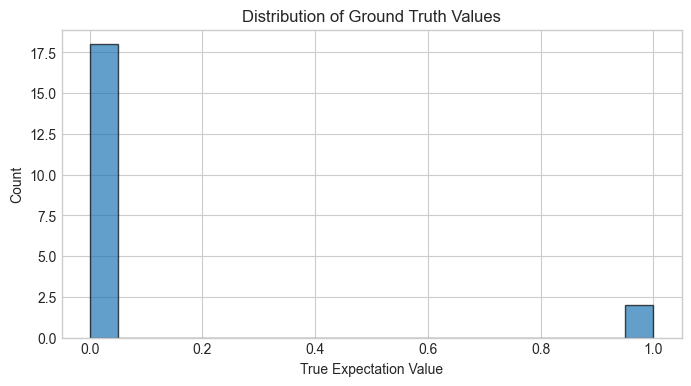

In [5]:
# Compute ground truth
ground_truth = compute_ground_truth(circuit, obs_set, 'benchmark_circuit')
truth_values = ground_truth.truth_values

# Statistics
truth_array = np.array(list(truth_values.values()))
print(f"Ground truth computed via: {ground_truth.truth_mode}")
print(f"Value range: [{truth_array.min():.4f}, {truth_array.max():.4f}]")
print(f"Mean: {truth_array.mean():.4f}")
print(f"Std: {truth_array.std():.4f}")

# Show histogram
plt.figure(figsize=(8, 4))
plt.hist(truth_array, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('True Expectation Value')
plt.ylabel('Count')
plt.title('Distribution of Ground Truth Values')
plt.show()

## 5. Protocol Execution

Run protocols at each shot budget with multiple replicates.

In [6]:
# Initialize protocols
protocols = [
    DirectGroupedProtocol(),
    DirectOptimizedProtocol(),
    ShadowsV0Protocol(),
]

print("Protocols:")
for p in protocols:
    print(f"  - {p.protocol_id} v{p.protocol_version}")

Protocols:
  - direct_grouped v1.0.0
  - direct_optimized v1.0.0
  - classical_shadows_v0 v1.0.0


In [7]:
# Run benchmark
all_results = {}  # (protocol_id, n_shots, rep) -> Estimates

for n_shots in CONFIG['n_shots_grid']:
    print(f"Running N={n_shots}...", end=' ')
    for protocol in protocols:
        for rep in range(CONFIG['n_replicates']):
            rep_seed = CONFIG['seed'] + rep * 1000 + n_shots
            
            estimates = simulate_protocol_execution(
                protocol=protocol,
                observable_set=obs_set,
                n_shots=n_shots,
                seed=rep_seed,
                true_expectations=truth_values,
                circuit=circuit,
            )
            all_results[(protocol.protocol_id, n_shots, rep)] = estimates
    print("done")

print(f"\nTotal configurations: {len(all_results)}")

Running N=100... done
Running N=500... done
Running N=1000... done
Running N=2000... done

Total configurations: 60


## 6. Results Analysis

In [8]:
# Build results DataFrame
rows = []
for (pid, n_shots, rep), estimates in all_results.items():
    for est in estimates.estimates:
        truth = truth_values.get(est.observable_id, np.nan)
        rows.append({
            'protocol_id': pid,
            'n_shots': n_shots,
            'replicate': rep,
            'observable_id': est.observable_id,
            'estimate': est.estimate,
            'se': est.se,
            'truth': truth,
            'error': abs(est.estimate - truth),
        })

df = pd.DataFrame(rows)
print(f"Results DataFrame: {len(df)} rows")
df.head()

Results DataFrame: 1200 rows


,protocol_id,n_shots,replicate,observable_id,estimate,se,truth,error
0,direct_grouped,100,0,obs_142f8605,0.090909,0.314918,0.0,0.090909
1,direct_grouped,100,0,obs_55ad10a1,-0.090909,0.314918,0.0,0.090909
2,direct_grouped,100,0,obs_bf92f15c,0.272727,0.304240,0.0,0.272727
3,direct_grouped,100,0,obs_bf1aec14,0.636364,0.243935,0.0,0.636364
4,direct_grouped,100,0,obs_a7f9ead3,0.090909,0.314918,0.0,0.090909


In [9]:
# Summary statistics by protocol and shot budget
summary = df.groupby(['protocol_id', 'n_shots']).agg({
    'se': ['mean', 'max'],
    'error': ['mean', 'max'],
}).round(4)

summary.columns = ['mean_se', 'max_se', 'mean_error', 'max_error']
print("Summary Statistics:")
summary

Summary Statistics:


mean_se  max_se  mean_error  max_error
protocol_id          n_shots                                        
classical_shadows_v0 100       0.3224  0.6614      0.2493     0.9000
                     500       0.1521  0.2645      0.1216     0.5400
                     1000      0.1080  0.2056      0.0945     0.3240
                     2000      0.0767  0.1322      0.0676     0.3240
direct_grouped       100       0.3044  0.3149      0.2891     1.4545
                     500       0.1347  0.1361      0.1989     1.4182
                     1000      0.0950  0.0953      0.1647     1.1712
                     2000      0.0671  0.0673      0.1426     1.0991
direct_optimized     100       0.2750  0.4041      0.3152     1.5385
                     500       0.1240  0.1622      0.1836     1.2059
                     1000      0.0878  0.1132      0.1612     1.1387
                     2000      0.0620  0.0798      0.1400     1.0773

## 7. Visualization

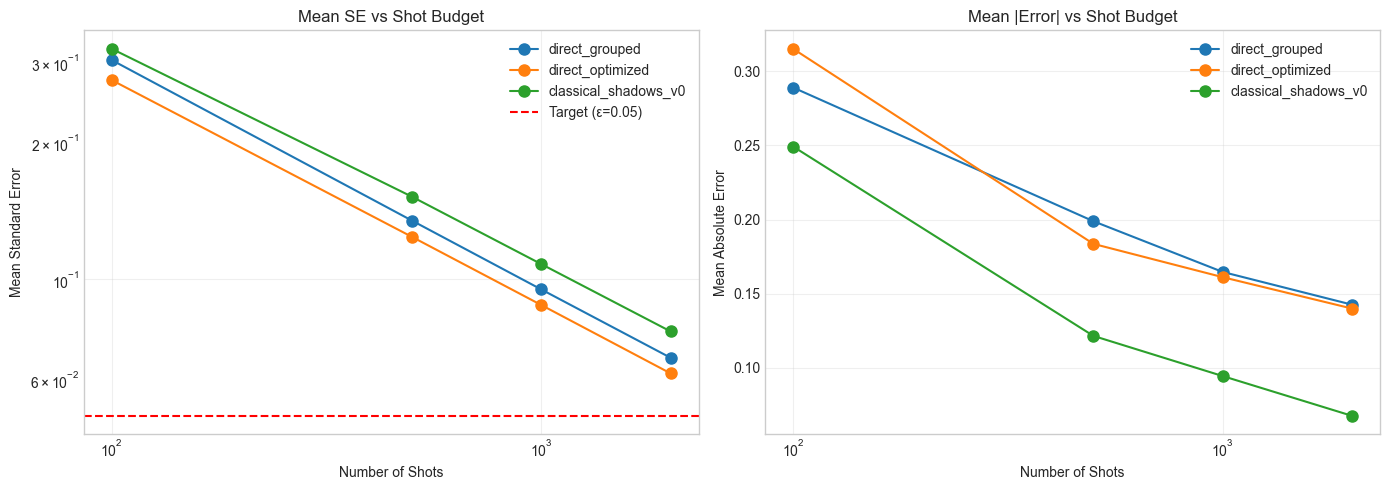

In [10]:
# Plot: Mean SE vs Shots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Mean SE scaling
for pid in df['protocol_id'].unique():
    data = df[df['protocol_id'] == pid].groupby('n_shots')['se'].mean()
    axes[0].plot(data.index, data.values, 'o-', label=pid, markersize=8)

axes[0].axhline(y=CONFIG['epsilon'], color='red', linestyle='--', label=f'Target (ε={CONFIG["epsilon"]})')
axes[0].set_xlabel('Number of Shots')
axes[0].set_ylabel('Mean Standard Error')
axes[0].set_title('Mean SE vs Shot Budget')
axes[0].legend()
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].grid(True, alpha=0.3)

# Right: Mean Error
for pid in df['protocol_id'].unique():
    data = df[df['protocol_id'] == pid].groupby('n_shots')['error'].mean()
    axes[1].plot(data.index, data.values, 'o-', label=pid, markersize=8)

axes[1].set_xlabel('Number of Shots')
axes[1].set_ylabel('Mean Absolute Error')
axes[1].set_title('Mean |Error| vs Shot Budget')
axes[1].legend()
axes[1].set_xscale('log')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
# SSF at largest N
max_n = max(CONFIG['n_shots_grid'])
results_at_max = {}

for protocol in protocols:
    protocol_df = df[(df['protocol_id'] == protocol.protocol_id) & (df['n_shots'] == max_n)]
    results_at_max[protocol.protocol_id] = protocol_df['se'].mean()

baseline = 'direct_grouped'
baseline_se = results_at_max[baseline]

print(f"Shot-Savings Factor at N={max_n} (baseline: {baseline}):")
print("-" * 50)
for pid, se in results_at_max.items():
    ssf = baseline_se / se if se > 0 else float('inf')
    print(f"  {pid:30s}: SSF = {ssf:.2f}x (SE = {se:.4f})")

Shot-Savings Factor at N=2000 (baseline: direct_grouped):
--------------------------------------------------
  direct_grouped                : SSF = 1.00x (SE = 0.0671)
  direct_optimized              : SSF = 1.08x (SE = 0.0620)
  classical_shadows_v0          : SSF = 0.87x (SE = 0.0767)


## 8. Bias-Variance Analysis

In [12]:
# Compute bias-variance for each protocol at max N
max_n = max(CONFIG['n_shots_grid'])

bias_var_results = []

for protocol in protocols:
    protocol_df = df[(df['protocol_id'] == protocol.protocol_id) & (df['n_shots'] == max_n)]
    
    # Group by observable
    for obs_id in protocol_df['observable_id'].unique():
        obs_df = protocol_df[protocol_df['observable_id'] == obs_id]
        estimates = obs_df['estimate'].values
        truth = obs_df['truth'].iloc[0]
        
        mean_est = np.mean(estimates)
        bias = mean_est - truth
        variance = np.var(estimates, ddof=1)
        mse = bias**2 + variance
        
        bias_var_results.append({
            'protocol_id': protocol.protocol_id,
            'observable_id': obs_id,
            'bias': bias,
            'variance': variance,
            'mse': mse,
            'rmse': np.sqrt(mse),
        })

bias_var_df = pd.DataFrame(bias_var_results)

# Summary
bv_summary = bias_var_df.groupby('protocol_id').agg({
    'bias': ['mean', 'std'],
    'variance': 'mean',
    'rmse': 'mean',
}).round(6)

print(f"Bias-Variance Analysis at N={max_n}:")
bv_summary

Bias-Variance Analysis at N=2000:


bias            variance      rmse
                          mean       std      mean      mean
protocol_id                                                 
classical_shadows_v0 -0.003460  0.033892  0.008621  0.086840
direct_grouped       -0.087838  0.304938  0.004088  0.154735
direct_optimized     -0.097098  0.305220  0.003617  0.152699

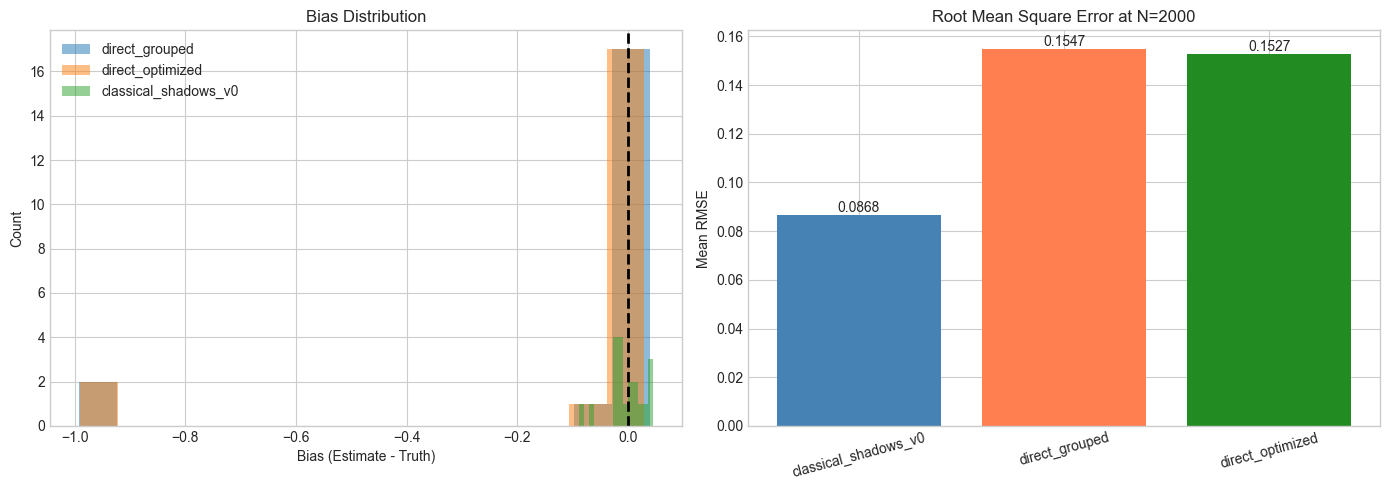

In [13]:
# Plot bias distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Bias distribution
for pid in bias_var_df['protocol_id'].unique():
    data = bias_var_df[bias_var_df['protocol_id'] == pid]['bias']
    axes[0].hist(data, bins=15, alpha=0.5, label=pid)

axes[0].axvline(x=0, color='black', linestyle='--', linewidth=2)
axes[0].set_xlabel('Bias (Estimate - Truth)')
axes[0].set_ylabel('Count')
axes[0].set_title('Bias Distribution')
axes[0].legend()

# Right: RMSE comparison
rmse_by_protocol = bias_var_df.groupby('protocol_id')['rmse'].mean()
colors = ['steelblue', 'coral', 'forestgreen']
bars = axes[1].bar(rmse_by_protocol.index, rmse_by_protocol.values, color=colors[:len(rmse_by_protocol)])
axes[1].set_ylabel('Mean RMSE')
axes[1].set_title(f'Root Mean Square Error at N={max_n}')
axes[1].tick_params(axis='x', rotation=15)

# Add value labels
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 9. FWER-Controlled Confidence Intervals

In [14]:
# Compute FWER CIs for each protocol at max N
max_n = max(CONFIG['n_shots_grid'])

print(f"FWER-Controlled CIs at N={max_n}:")
print("=" * 60)

for protocol in protocols:
    # Get estimates from first replicate
    est = all_results[(protocol.protocol_id, max_n, 0)]
    estimates = [e.estimate for e in est.estimates]
    ses = [e.se for e in est.estimates]
    
    # Construct CIs
    sim_cis = construct_simultaneous_cis(
        estimates=estimates,
        standard_errors=ses,
        alpha=CONFIG['delta'],
        fwer_method=FWERMethod.BONFERRONI,
    )
    
    # Check coverage
    truths = [truth_values[e.observable_id] for e in est.estimates]
    coverage = sim_cis.coverage_fraction(truths)
    all_covered = sim_cis.all_contain(truths)
    
    print(f"\n{protocol.protocol_id}:")
    print(f"  FWER method: {sim_cis.fwer_adjustment.method.value}")
    print(f"  Nominal coverage: {sim_cis.coverage_guarantee:.1%}")
    print(f"  Empirical per-obs coverage: {coverage:.1%}")
    print(f"  Family-wise coverage: {all_covered}")

FWER-Controlled CIs at N=2000:

direct_grouped:
  FWER method: bonferroni
  Nominal coverage: 95.0%
  Empirical per-obs coverage: 90.0%
  Family-wise coverage: False

direct_optimized:
  FWER method: bonferroni
  Nominal coverage: 95.0%
  Empirical per-obs coverage: 90.0%
  Family-wise coverage: False

classical_shadows_v0:
  FWER method: bonferroni
  Nominal coverage: 95.0%
  Empirical per-obs coverage: 100.0%
  Family-wise coverage: True


## 10. Summary

In [15]:
# Final summary table
print("=" * 80)
print("BENCHMARK SUMMARY")
print("=" * 80)
print(f"\nConfiguration:")
print(f"  Circuit: {CONFIG['circuit_type']}, {CONFIG['n_qubits']} qubits")
print(f"  Observables: {CONFIG['n_observables']}")
print(f"  Shot grid: {CONFIG['n_shots_grid']}")
print(f"  Replicates: {CONFIG['n_replicates']}")

print(f"\nResults at N={max_n}:")
print("-" * 80)
print(f"{'Protocol':<30} {'Mean SE':<12} {'Max SE':<12} {'Mean |Err|':<12} {'SSF':<10}")
print("-" * 80)

for protocol in protocols:
    pid = protocol.protocol_id
    protocol_df = df[(df['protocol_id'] == pid) & (df['n_shots'] == max_n)]
    mean_se = protocol_df['se'].mean()
    max_se = protocol_df['se'].max()
    mean_err = protocol_df['error'].mean()
    ssf = baseline_se / mean_se if mean_se > 0 else float('inf')
    
    print(f"{pid:<30} {mean_se:<12.4f} {max_se:<12.4f} {mean_err:<12.4f} {ssf:<10.2f}x")

print("=" * 80)
print("\nFor publication-grade results, increase n_replicates to >= 10.")

BENCHMARK SUMMARY

Configuration:
  Circuit: ghz, 4 qubits
  Observables: 20
  Shot grid: [100, 500, 1000, 2000]
  Replicates: 5

Results at N=2000:
--------------------------------------------------------------------------------
Protocol                       Mean SE      Max SE       Mean |Err|   SSF       
--------------------------------------------------------------------------------
direct_grouped                 0.0671       0.0673       0.1426       1.00      x
direct_optimized               0.0620       0.0798       0.1400       1.08      x
classical_shadows_v0           0.0767       0.1322       0.0676       0.87      x

For publication-grade results, increase n_replicates to >= 10.


---

## Conclusions

This notebook demonstrated:

1. **Ground truth computation** via statevector simulation for exact reference values
2. **Protocol comparison** between classical shadows and direct measurement baselines
3. **Statistical analysis** with FWER-controlled confidence intervals
4. **Bias-variance decomposition** for estimator quality assessment

### Key Observations

- Direct grouped/optimized protocols tend to have lower variance for small observable sets
- Classical shadows become more efficient as the number of observables increases
- The SSF metric captures the relative shot efficiency between protocols

### Next Steps

- Increase `n_replicates` for publication-grade statistics
- Extend `n_shots_grid` to find N* (shots-to-target)
- Try different circuit types and observable sets
- Compare with noise-aware shadows (ShadowsV1Protocol)